# Build random forest traing sets

This notebook contains code used to build random forest traingin sets

This has all been rolled into other libraries and such so it is mostly for archive purposes. 2020-01-29 rws

In [1]:
from multigrids import TemporalGrid, MultiGrid, TemporalMultiGrid
from atm.images import raster
import os

data_dir = ('data/V1/')
# os.listdir(data_dir)
fdd = TemporalGrid(os.path.join(data_dir, 'degree-day/freezing/ACP/v2/temporal-grid/ACP_FDD.yml'))
fdd.config['ts_offset'] = 0

tdd = TemporalGrid(os.path.join(data_dir, 'degree-day/thawing/ACP/v2/temporal-grid/ACP-TDD.yml'))
tdd.config['ts_offset'] = 0

tdd_p1 = TemporalGrid(os.path.join(data_dir, 'degree-day/thawing/ACP/v2/temporal-grid/ACP-TDD.yml'))
tdd_p1.config['ts_offset'] = 1

ewp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/early-winter/ACP/v2/temporal-grid/ACP_early_winter_precip_mm.yml')
)
ewp.config['ts_offset'] = 0

fwp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/full-winter/ACP/v2/temporal-grid/ACP_full_winter_precip_mm.yml')
)
fwp.config['ts_offset'] = 0

lsp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/late-summer/ACP/v2/temporal-grid/ACP_late_summer_precip_mm.yml')
)
lsp.config['ts_offset'] = 0

sp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/summer/ACP/v2/temporal-grid/ACP_summer_precip_mm.yml')
)
sp.config['ts_offset'] = 0

sp_p1 = TemporalGrid(
    os.path.join(data_dir, 'precipitation/summer/ACP/v2/temporal-grid/ACP_summer_precip_mm.yml')
)
sp_p1.config['ts_offset'] = 0

# geoloc = MultiGrid(os.path.join('geolocation/geolocation/ACP/v1/multigrid/ACP-geolocation.yml'))
lat, md = raster.load_raster(os.path.join(data_dir, 'geolocation/geolocation/ACP/v1/ACP-geolocation_lat.tif' ))
long, md = raster.load_raster(os.path.join(data_dir, 'geolocation/geolocation/ACP/v1/ACP-geolocation_long.tif' ))
aspect, md = raster.load_raster(os.path.join(data_dir, 'geolocation/aspect/ACP/v1/ACP-ASPECT1000m.tif' ))
slope, md = raster.load_raster(os.path.join(data_dir, 'geolocation/slope/ACP/v1/ACP-SLOPE1000m.tif' ))
elev, md = raster.load_raster(os.path.join(data_dir, 'geolocation/elevation/ACP/v1/ACP-DEM1000m.tif' ))



In [2]:
tki = TemporalGrid(os.path.join(data_dir, 
    'thermokarst/initiation-regions/ACP/v3-1/PDM-5var/with_predisp/temporal-grid/ia_grid_5var_with_predisp.yml'))
tki[1901]

memmap([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]], dtype=float32)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
years = fdd.config['real_shape'][0]
rows = fdd.config['real_shape'][1]
cols = fdd.config['real_shape'][2]
grid_names = ['fdd', 'tdd', 'tdd+1', 'ewp', 'fwp', 'sp', 'lsp', 'sp+1', 'lat', 'long','aspect','slope', 'elev' ]
grids = len(grid_names)

trainset = TemporalMultiGrid(rows,cols,grids,years, grid_names = grid_names)
trainset.config['start_timestep'] = 1901

trainset['lat'][:] = lat
trainset['long'][:] = long
trainset['elev'][:] = elev
trainset['slope'][:] = slope
trainset['aspect'][:] = aspect

trainset['fdd'][:] = fdd.grids.reshape((years,rows,cols))[:]


trainset['tdd'][1:] = tdd_p1.grids.reshape((years ,rows,cols))[:-1]
trainset['tdd+1'][:] = tdd.grids.reshape((years,rows,cols))[:]

trainset['ewp'][:] = ewp.grids.reshape((years,rows,cols))[:]
trainset['fwp'][1:] = fwp.grids.reshape((years-1,rows,cols))[:]

trainset['sp'][1:] = sp.grids.reshape((years,rows,cols))[:-1]
trainset['lsp'][:] = lsp.grids.reshape((years,rows,cols))[:]

trainset['sp+1'][:] = sp_p1.grids.reshape((years ,rows,cols))[:]


trainset.grids[trainset.grids == -9999] = np.nan



In [17]:
mask = np.isnan(trainset[grid_names[0], 2015]) == False
for grid in grid_names[1:]:
    mask = np.logical_and(
        np.isnan(trainset[grid, 2015])== False, mask)
    
trainset.config['mask'] = mask

In [18]:
trainset.config['start_timestep'] = 1901
print(np.allclose(trainset['tdd', 1952], trainset['tdd+1',1951], equal_nan=True) )
print(np.allclose(trainset['sp', 1952], trainset['sp+1',1951], equal_nan=True) )

True
True


In [20]:
y=2015
def show(data, title):
    plt.matshow(data)
    plt.title(title)
    plt.colorbar()
    plt.show()
# show(trainset['lat',y], 'lat')
# show(trainset['long',y], 'long')
# show(trainset['elev',y], 'elev')
# show(trainset['slope',y], 'slope')
# show(trainset['aspect',y], 'aspect')

# show(trainset['fdd',y], 'fdd')
# show(trainset['tdd',y], 'tdd')
# show(trainset['tdd+1',y], 'tdd+1')

# show(trainset['ewp',y], 'ewp')
# show(trainset['fwp',y], 'fwp')
# show(trainset['lsp',y], 'lsp')
# show(trainset['sp',y], 'sp')

# show(trainset['sp+1',y], 'sp+1')

# plt.imshow(mask)

In [21]:
def get_as_ml_features(self, mask = None, train_range = None):
    features = [ [] for g in range(self.config['num_grids']) ]
    if mask is None:
        mask = self.config['mask']
    
    if train_range is None:
        train_range = self.get_range()
    
    for ts in train_range:
        for grid, gnum in self.config['grid_name_map'].items():
#             print(grid, '\t',gnum, '\t',self[grid, ts][mask].shape, '\t', self[grid, ts][mask])

            features[gnum] += list(self[grid, ts][mask])

        
    return np.array(features)
# trainset.get_as_ml_features(None, None, [1902,1950])
features = get_as_ml_features(trainset, trainset.config['mask'], range(1902, 2016))
features.shape

(13, 34312176)

In [22]:
# show(trainset[1902].reshape(13,415*1096)[0].reshape(415,1096), 'test')
trainset.config['num_grids']

13

In [23]:
labels = tki.get_as_ml_features(None, trainset.config['mask'], range(1902, 2016))

In [24]:
labels.shape

(34312176,)

In [25]:
def get_data_subsample(features, labels, percent=.50):
    """return a random subsample of data set
    
    using a “discrete uniform” distribution
    
    Parameters
    ----------
    features: np.array [n_features, n_samples]
        the features array
    labels: np.array [n_samples]
    percent: float [0, 1]
        percent of data to keep
        
    Returns 
    -------
    np.array[n_features, n_samples * percent]
        randomly subsampled feature array 
    np.array[n_features, n_samples * percent]
        randomly subsampled lable array using same 
        index as sampling feature array
    """
    _max = features.shape[1]
    keep = int(_max * percent)
    idx = np.random.randint(_max, size=keep)
    return features.T[idx].T, labels[idx]

flabels = ['' for g in range(trainset.config['num_grids']) ]
for grid, gnum in trainset.config['grid_name_map'].items():
    flabels[gnum] = grid
# features
# labels

In [26]:
ss_f, ss_l = get_data_subsample(features, labels)

In [27]:
features.shape[1], labels.shape[0]

(34312176, 34312176)

In [28]:
ss_f.shape

(13, 17156088)

In [29]:
ss_sample = MultiGrid(1, 17156088, 14, grid_names=grid_names+['tki'])

In [30]:
for idx, grid in enumerate(grid_names):
    ss_sample[grid][:] = ss_f[idx]
#     print(idx,grid)

ss_sample['tki'] = ss_l

In [31]:
ss_sample

[[[-4.3856841e+03 -4.9607021e+03 -6.0480229e+03 ... -4.0220249e+03
   -4.8283369e+03 -5.1962524e+03]]

 [[ 4.8839673e+02  7.1733929e+02  8.6527155e+02 ...  1.1063896e+03
    9.0382349e+02  8.5500623e+02]]

 [[ 4.9684235e+02  8.1007941e+02  9.0797968e+02 ...  1.0372502e+03
    8.7209985e+02  8.4540643e+02]]

 ...

 [[ 7.9106525e-02  1.5403687e+00  4.6689314e-01 ...  2.4084113e+00
    2.8431985e-01  1.0506195e+00]]

 [[ 2.4600000e+02  2.2500000e+02  2.4700000e+02 ...  2.4000000e+02
    2.3900000e+02  2.3000000e+02]]

 [[-9.6383982e+00  1.3922821e+00  8.2922602e-01 ...  1.7546987e-02
   -4.5708925e-01 -7.4737191e-01]]]

In [32]:
from pandas import read_csv, get_dummies, DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import datetime

In [33]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 42, max_leaf_nodes=1000, verbose=2, n_jobs=4)
rf.fit(ss_f.T, ss_l)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 14.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=1000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [34]:
rf.feature_importances_

array([0.06539879, 0.06088645, 0.05353563, 0.03087624, 0.33164993,
       0.03011832, 0.02607648, 0.09347746, 0.14813731, 0.15859494,
       0.        , 0.00124844, 0.        ])

In [39]:
fid = {}
for i, v in enumerate(flabels):
    fid[v] = rf.feature_importances_[i]*100

In [40]:
fid

{'fdd': 6.539878935961152,
 'tdd': 6.088644504309254,
 'tdd+1': 5.353563444981208,
 'ewp': 3.0876241636843327,
 'fwp': 33.16499345328187,
 'sp': 3.0118321233499814,
 'lsp': 2.6076479067283005,
 'sp+1': 9.347746435910805,
 'lat': 14.813731197825303,
 'long': 15.85949411159061,
 'aspect': 0.0,
 'slope': 0.1248437223771687,
 'elev': 0.0}

In [161]:
ty = 1965

pf = trainset[ty]
test_f = []
for f in pf:
#     print(f[mask])
    test_f.append(list(f[mask]))
# rf.predicttrainset
test_f = np.array(test_f)
test_r = rf.predict(test_f.T)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


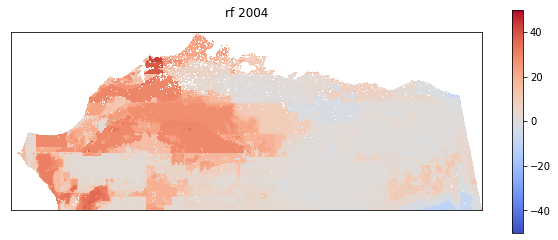

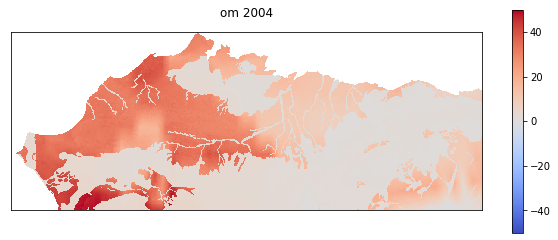

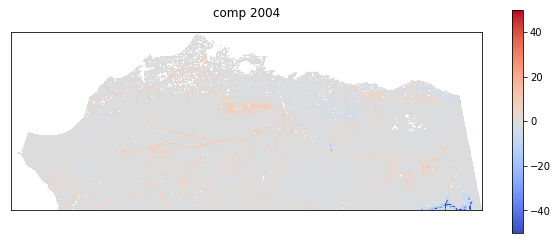

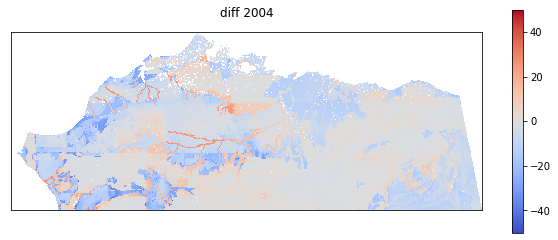

In [155]:
test_map = np.zeros([415,1096]) - np.nan
test_map[mask]= test_r
def show2 (data, title, save =False):
    plt.matshow(data, vmin=-50, vmax=50, cmap='coolwarm')
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    if save:
        plt.savefig( title + '.png')

# show2(test_map, 'rf '+str(ty))
# show2(tki[ty], 'om '+str(ty))
# show2((test_map - tki[ty])/ np.abs(tki[ty]), 'comp ' +str(ty))
show2(test_map, 'rf '+str(ty), save=True)
show2(tki[ty], 'om '+str(ty),save=True)
show2((test_map - tki[ty])/ np.abs(tki[ty]), 'comp ' +str(ty),save=True)
show2((test_map - tki[ty]), 'diff ' +str(ty),save=True)



In [99]:
import pickle
def save_rf_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump( model,f)

In [101]:
save_rf_model(rf, "rfm_e10_rs42_mln1000.pickle")

In [102]:
ss_sample.save('rfm_e10_rs42_mln1000/training_data.yml')

In [104]:
trainset.save('rf_traing_set_v1.yml')

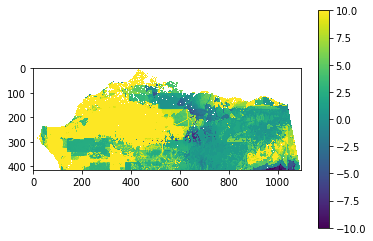

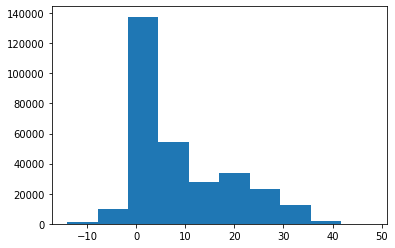

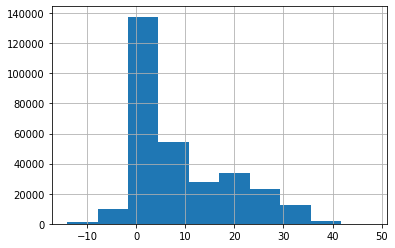

In [163]:
plt.imshow((test_map - tki[ty]), vmin=-10,vmax=10)
plt.colorbar()
plt.show()

diff = (test_map - tki[ty])

plt.hist(diff[mask])
plt.show()
from pandas import Series

ds = Series(diff[mask])
ds.hist()
plt.savefig('histogram' + str(ty) + '.png')

# diff[mask].mean(), diff[mask].std(), diff[mask].min(),diff[mask].max() 